<a href="https://colab.research.google.com/github/Anaqqa/4DVST---Data-Visualization/blob/main/VF_09_04_TP_4DVST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Analyse terminée. Les visualisations ont été sauvegardées.


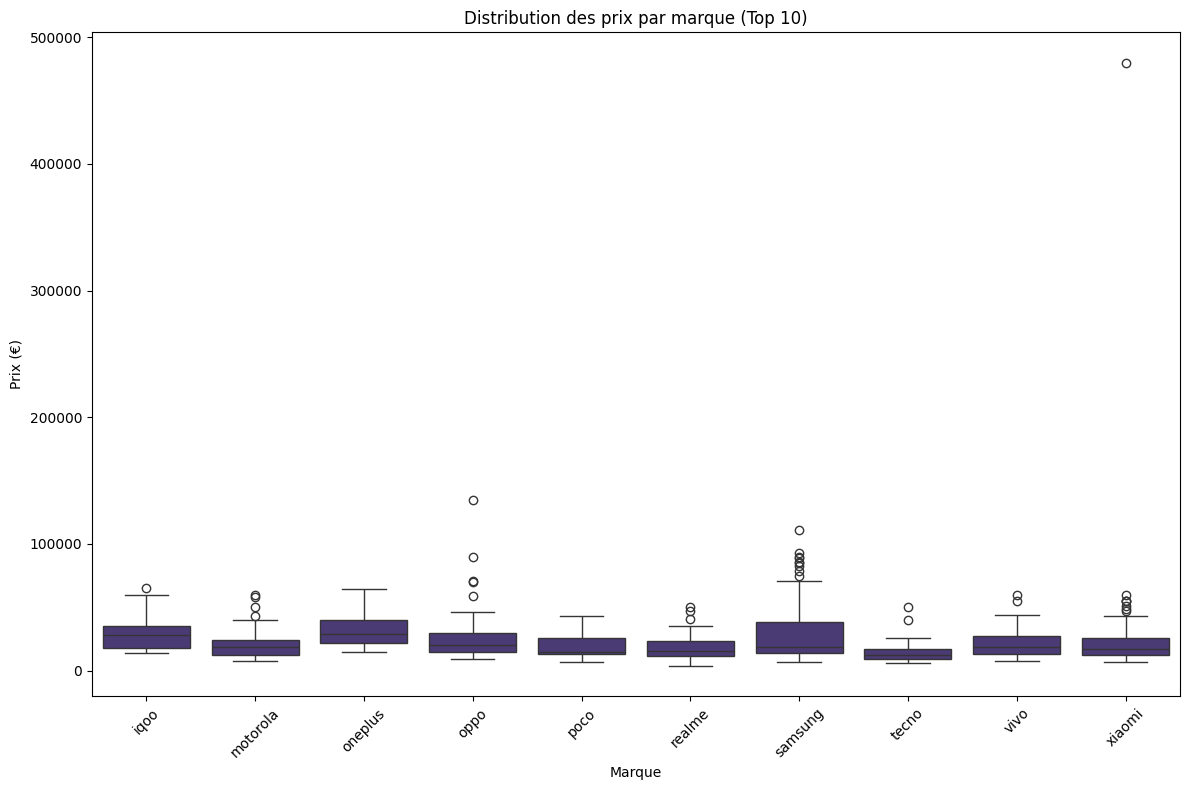

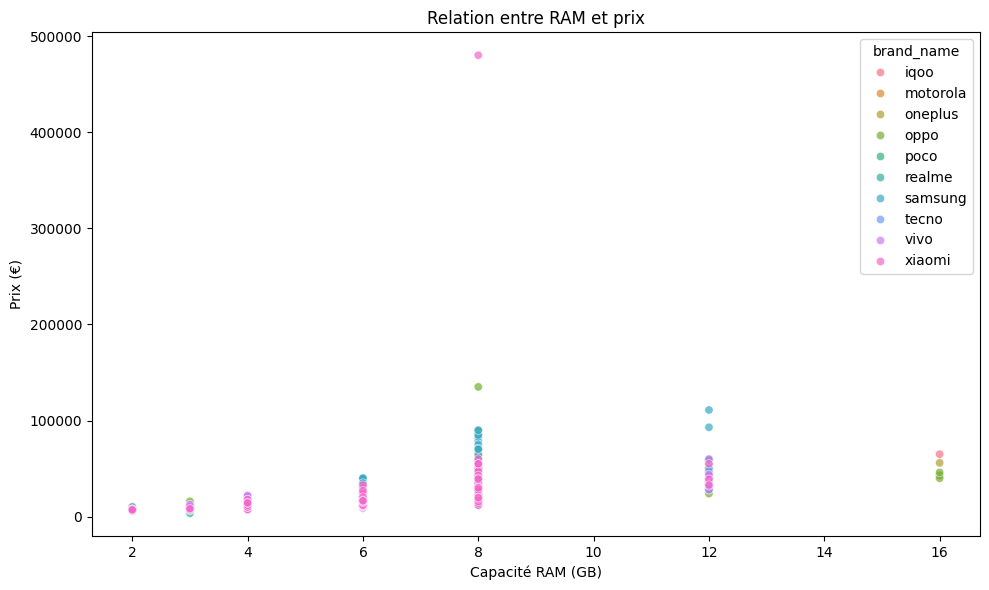

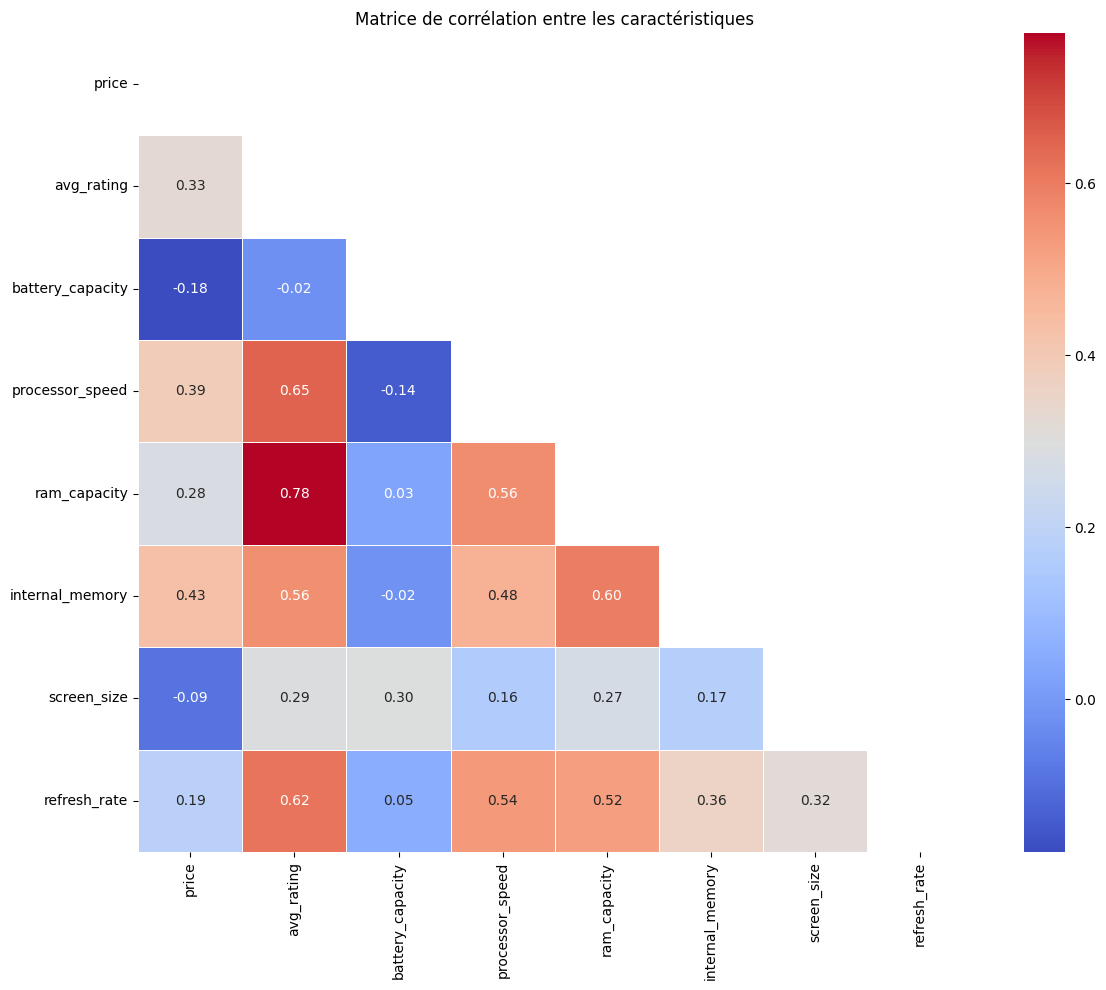

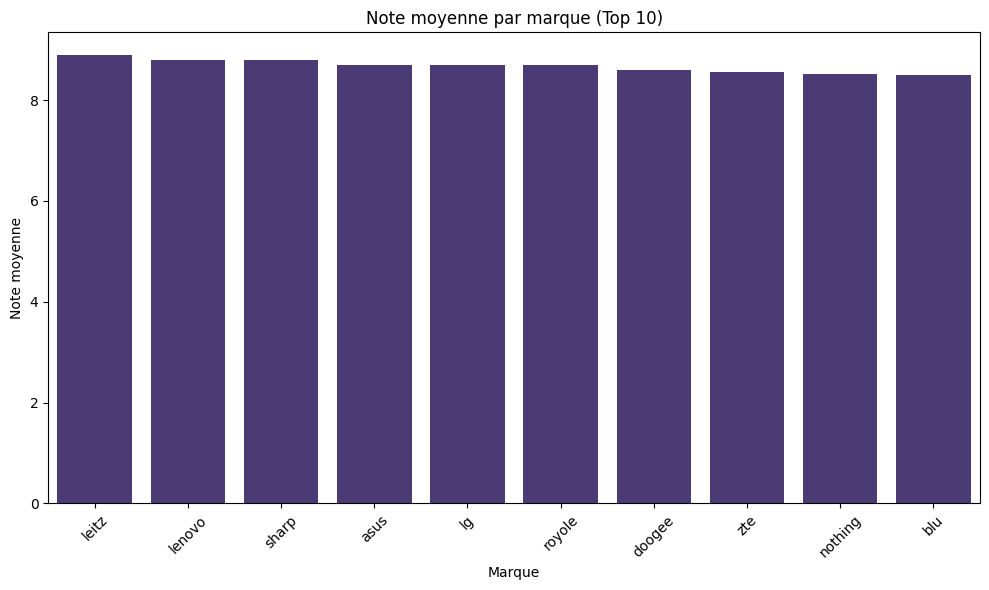

In [20]:
"""
Module d'analyse de données de smartphones.

Ce script réalise une analyse complète des données de smartphones,
incluant l'extraction des données, le prétraitement, le calcul
et la génération de visualisations.
"""

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def extract_data(file_path):
    """
    Extrait les données du fichier CSV.

    Args:
        file_path (str): Chemin vers le fichier CSV.

    Returns:
        pd.DataFrame: DataFrame contenant les données.
    """
    data = pd.read_csv(file_path)
    return data

def preprocess_data(data):
    """
    Prétraite les données pour l'analyse.

    Args:
        data (pd.DataFrame): DataFrame brut.

    Returns:
        pd.DataFrame: DataFrame prétraité.
    """
    # Copie du DataFrame pour éviter les modifications sur l'original
    df = data.copy()

    # Conversion des types
    numeric_columns = ['price', 'avg_rating', 'battery_capacity',
                      'processor_speed', 'ram_capacity', 'internal_memory',
                      'screen_size', 'refresh_rate']

    # Suppression des lignes avec des valeurs manquantes dans les colonnes importantes
    df = df.dropna(subset=numeric_columns)

    # Conversion des colonnes binaires
    binary_columns = ['5G_or_not', 'fast_charging_available', 'extended_memory_available']
    for col in binary_columns:
        df[col] = df[col].astype(int)

    # Formatage des prix en supprimant d'éventuels caractères non numériques
    if df['price'].dtype == 'object':
        df['price'] = df['price'].str.replace('[^\d.]', '', regex=True).astype(float)

    return df

def compute_statistics(data):
    """
    Calcule les statistiques descriptives sur les données.

    Args:
        data (pd.DataFrame): DataFrame prétraité.

    Returns:
        dict: Dictionnaire contenant les statistiques calculées.
    """
    stats = {}

    # Statistiques de base par marque
    stats['brand_stats'] = data.groupby('brand_name').agg({
        'price': ['mean', 'median', 'min', 'max', 'count'],
        'avg_rating': 'mean',
        'battery_capacity': 'mean',
        'ram_capacity': 'mean'
    }).reset_index()

    # Top 5 des modèles les mieux notés
    stats['top_rated'] = data.sort_values('avg_rating', ascending=False).head(10)

    # Corrélation entre le prix et les autres caractéristiques
    numeric_cols = ['price', 'avg_rating', 'battery_capacity', 'processor_speed',
                    'ram_capacity', 'internal_memory', 'screen_size', 'refresh_rate']
    stats['correlations'] = data[numeric_cols].corr()

    # Relation entre 5G et prix
    stats['5g_price_comparison'] = data.groupby('5G_or_not')['price'].agg(['mean', 'median'])

    # Comparaison RAM/prix par marque (pour les principales marques)
    top_brands = data['brand_name'].value_counts().nlargest(5).index
    stats['ram_price_by_brand'] = data[data['brand_name'].isin(top_brands)].groupby(['brand_name', 'ram_capacity'])['price'].mean().reset_index()

    return stats

def generate_plots_basic(data, stats):
    """
    Génère les visualisations.

    Args:
        data (pd.DataFrame): DataFrame prétraité.
        stats (dict): Statistiques calculées.

    Returns:
        dict: Dictionnaire contenant les figures générées.
    """
    figures = {}

    # Initialisation de la palette de couleurs
    sns.set_palette("viridis")

    # 1. Distribution des prix par marque (Top 10)
    plt.figure(figsize=(12, 8))
    top_brands = data['brand_name'].value_counts().nlargest(10).index
    brand_price_data = data[data['brand_name'].isin(top_brands)]

    ax = sns.boxplot(x='brand_name', y='price', data=brand_price_data)
    ax.set_title('Distribution des prix par marque (Top 10)')
    ax.set_xlabel('Marque')
    ax.set_ylabel('Prix (€)')
    ax.tick_params(axis='x', rotation=45)
    plt.tight_layout()
    figures['price_distribution'] = plt.gcf()

    # 2. Relation entre RAM et prix
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='ram_capacity', y='price', hue='brand_name',
                   data=data[data['brand_name'].isin(top_brands)], alpha=0.7)
    plt.title('Relation entre RAM et prix')
    plt.xlabel('Capacité RAM (GB)')
    plt.ylabel('Prix (€)')
    plt.tight_layout()
    figures['ram_price_scatter'] = plt.gcf()

    # 3. Corrélation entre les caractéristiques numériques
    plt.figure(figsize=(12, 10))
    corr_matrix = stats['correlations']
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title('Matrice de corrélation entre les caractéristiques')
    plt.tight_layout()
    figures['correlation_matrix'] = plt.gcf()

    # 4. Note moyenne par marque (Top 10)
    plt.figure(figsize=(10, 6))
    avg_rating_by_brand = data.groupby('brand_name')['avg_rating'].mean().sort_values(ascending=False).head(10)
    sns.barplot(x=avg_rating_by_brand.index, y=avg_rating_by_brand.values)
    plt.title('Note moyenne par marque (Top 10)')
    plt.xlabel('Marque')
    plt.ylabel('Note moyenne')
    plt.xticks(rotation=45)
    plt.tight_layout()
    figures['avg_rating_by_brand'] = plt.gcf()

    return figures

def generate_plots_advanced(data, stats):
    """
    Génère les visualisations améliorées (Day 5).

    Args:
        data (pd.DataFrame): DataFrame prétraité.
        stats (dict): Statistiques calculées.

    Returns:
        dict: Dictionnaire contenant les figures générées.
    """
    figures = {}

    # Utilisation d'une palette cohérente et accessible
    colors = px.colors.qualitative.G10

    # 1. Distribution des prix par marque (Amélioré avec Plotly)
    top_brands = data['brand_name'].value_counts().nlargest(8).index
    brand_price_data = data[data['brand_name'].isin(top_brands)]

    fig = px.box(brand_price_data, x='brand_name', y='price',
                color='brand_name', title='Distribution des prix par marque',
                labels={'brand_name': 'Marque', 'price': 'Prix (€)'},
                color_discrete_sequence=colors)

    fig.update_layout(
        title_font_size=22,
        xaxis_title_font_size=16,
        yaxis_title_font_size=16,
        legend_title_font_size=14,
        showlegend=False,
        height=600,
        width=900,
        template='plotly_white'
    )

    figures['price_distribution_advanced'] = fig

    # 2. Relation entre RAM, prix et autres caractéristiques (Bubble chart)
    top5_brands = data['brand_name'].value_counts().nlargest(5).index
    bubble_data = data[data['brand_name'].isin(top5_brands)]

    fig = px.scatter(bubble_data, x='ram_capacity', y='price', color='brand_name',
                    size='battery_capacity', hover_name='model',
                    hover_data=['processor_brand', 'screen_size', 'avg_rating'],
                    title='Relation entre RAM, prix et capacité de batterie',
                    labels={'ram_capacity': 'RAM (GB)', 'price': 'Prix (€)',
                           'brand_name': 'Marque', 'battery_capacity': 'Capacité de batterie (mAh)'},
                    color_discrete_sequence=colors)

    fig.update_layout(
        title_font_size=22,
        xaxis_title_font_size=16,
        yaxis_title_font_size=16,
        legend_title_font_size=14,
        height=700,
        width=1000,
        template='plotly_white'
    )

    figures['ram_price_advanced'] = fig

    # 3. Matrice de corrélation interactive
    corr_matrix = stats['correlations']

    # Préparation des données pour le heatmap
    z = corr_matrix.values
    x = corr_matrix.columns
    y = corr_matrix.columns

    # Création du heatmap avec une échelle de couleurs plus intuitive
    heatmap = go.Heatmap(
        z=z,
        x=x,
        y=y,
        colorscale='RdBu_r',
        zmin=-1, zmax=1,
        text=np.round(z, 2),
        texttemplate='%{text:.2f}',
        showscale=True
    )

    fig = go.Figure(data=heatmap)

    fig.update_layout(
        title='Matrice de corrélation des caractéristiques',
        title_font_size=22,
        height=700,
        width=800,
        template='plotly_white'
    )

    figures['correlation_matrix_advanced'] = fig

    # 4. Dashboard comparatif des caractéristiques principales par marque
    top6_brands = data['brand_name'].value_counts().nlargest(6).index
    brand_comparison = data[data['brand_name'].isin(top6_brands)]

    # Création d'un subplots avec 4 graphiques
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=(
            'Prix moyen',
            'Note moyenne',
            'Capacité de batterie moyenne',
            'Capacité RAM moyenne'
        )
    )

    # Prix moyen
    price_by_brand = brand_comparison.groupby('brand_name')['price'].mean().reset_index()
    price_by_brand = price_by_brand.sort_values('price', ascending=False)

    fig.add_trace(
        go.Bar(
            x=price_by_brand['brand_name'],
            y=price_by_brand['price'],
            marker_color=colors[:len(price_by_brand)],
            text=price_by_brand['price'].round().astype(int),
            textposition='auto',
            name='Prix moyen'
        ),
        row=1, col=1
    )

    # Note moyenne
    rating_by_brand = brand_comparison.groupby('brand_name')['avg_rating'].mean().reset_index()
    rating_by_brand = rating_by_brand.sort_values('avg_rating', ascending=False)

    fig.add_trace(
        go.Bar(
            x=rating_by_brand['brand_name'],
            y=rating_by_brand['avg_rating'],
            marker_color=colors[:len(rating_by_brand)],
            text=rating_by_brand['avg_rating'].round(2),
            textposition='auto',
            name='Note moyenne'
        ),
        row=1, col=2
    )

    # Capacité de batterie moyenne
    battery_by_brand = brand_comparison.groupby('brand_name')['battery_capacity'].mean().reset_index()
    battery_by_brand = battery_by_brand.sort_values('battery_capacity', ascending=False)

    fig.add_trace(
        go.Bar(
            x=battery_by_brand['brand_name'],
            y=battery_by_brand['battery_capacity'],
            marker_color=colors[:len(battery_by_brand)],
            text=battery_by_brand['battery_capacity'].round().astype(int),
            textposition='auto',
            name='Capacité batterie'
        ),
        row=2, col=1
    )

    # Capacité RAM moyenne
    ram_by_brand = brand_comparison.groupby('brand_name')['ram_capacity'].mean().reset_index()
    ram_by_brand = ram_by_brand.sort_values('ram_capacity', ascending=False)

    fig.add_trace(
        go.Bar(
            x=ram_by_brand['brand_name'],
            y=ram_by_brand['ram_capacity'],
            marker_color=colors[:len(ram_by_brand)],
            text=ram_by_brand['ram_capacity'].round(1),
            textposition='auto',
            name='RAM moyenne'
        ),
        row=2, col=2
    )

    fig.update_layout(
        height=800,
        width=1000,
        title_text='Comparaison des caractéristiques par marque',
        title_font_size=24,
        showlegend=False,
        template='plotly_white'
    )

    figures['brand_comparison_dashboard'] = fig

    return figures

def save_figures(figures, basic_path='visualisations_basic', advanced_path='visualisations_advanced'):
    """
    Sauvegarde les figures générées.

    Args:
        figures (dict): Dictionnaire contenant les figures.
        basic_path (str): Chemin pour enregistrer les visualisations de base.
        advanced_path (str): Chemin pour enregistrer les visualisations avancées.
    """
    # Création des dossiers si nécessaire
    import os
    if not os.path.exists(basic_path):
        os.makedirs(basic_path)
    if not os.path.exists(advanced_path):
        os.makedirs(advanced_path)

    # Sauvegarde des visualisations de base (Matplotlib/Seaborn)
    basic_figs = ['price_distribution', 'ram_price_scatter', 'correlation_matrix', 'avg_rating_by_brand']
    for fig_name in basic_figs:
        if fig_name in figures:
            figures[fig_name].savefig(f'{basic_path}/{fig_name}.png', dpi=300, bbox_inches='tight')

    # Sauvegarde des visualisations avancées (Plotly)
    advanced_figs = ['price_distribution_advanced', 'ram_price_advanced',
                     'correlation_matrix_advanced', 'brand_comparison_dashboard']
    for fig_name in advanced_figs:
        if fig_name in figures:
            figures[fig_name].write_html(f'{advanced_path}/{fig_name}.html')
            figures[fig_name].write_image(f'{advanced_path}/{fig_name}.png')

def main():
    """
    Fonction principale qui exécute l'analyse complète.
    """
    # Extraction des données
    data = extract_data('smartphones.csv')

    # Prétraitement
    processed_data = preprocess_data(data)

    # Calcul des statistiques
    stats = compute_statistics(processed_data)

    # Génération des visualisations de base (Day 2)
    basic_figures = generate_plots_basic(processed_data, stats)

    # Génération des visualisations améliorées (Day 5)
    advanced_figures = generate_plots_advanced(processed_data, stats)

    # Combinaison des figures
    all_figures = {**basic_figures, **advanced_figures}

    # Sauvegarde des figures
    save_figures(all_figures)

    print("Analyse terminée. Les visualisations ont été sauvegardées.")

if __name__ == "__main__":
    main()